In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
from models.gru import GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust12-20_spw"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "vdata_T0.3_Ne2240_gA0.6_tauA1_gN0.8_Ni200_gG0.7_gB1.2_Er9_Ir30_balanced_rep1000_stimseed1.npy"
#V_file = "V_diff_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file).reshape(-1,20,1501)[:,:,:1500].flatten()
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
V -= torch.mean(V)

C_syn_e = np.load("/media/hdd01/sklee/CA1_clust12-20_spw/data/handsub18_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_clust12-20_spw/data/handsub18_C_syn_i.npy")
#C_syn_e = np.ones((1,2240))
#C_syn_i = np.ones((1,200))

C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

In [3]:
T_train = 980 * 300 * 5 * 20
T_test = 1 * 300 * 5 * 20
H_no = 20
sub_no = 18
E_no = 2240
I_no = 200
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 30000
batch_size = 2
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[-T_test:].to(device).float()

test_E_neural = E_neural[-T_test:].toarray()
test_I_neural = I_neural[-T_test:].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
#model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.03**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.03)

# GRU (1 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

27659


In [6]:
score_list = []

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device).float()
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device).float()
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #####
    batch_E_neural = batch_E_neural.reshape(batch_size*20, batch_length//20, -1)
    batch_I_neural = batch_I_neural.reshape(batch_size*20, batch_length//20, -1)
    batch_V = batch_V.reshape(batch_size*20, batch_length//20)
    ######
    
    #V_pred, _, _ = model(batch_E_neural, batch_I_neural)
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    s = time.time()
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        
        #####
        test_E_neural = test_E_neural.reshape(20,1500,-1)
        test_I_neural = test_I_neural.reshape(20,1500,-1)
        V_test = V_test.reshape(20,1500)
        #####
        
        #test_V_pred, test_sub_out, _ = model(test_E_neural, test_I_neural)
        test_V_pred, test_sub_out = model(test_E_neural, test_I_neural)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.flatten().cpu().detach().numpy(), test_V_pred.flatten().cpu().detach().numpy())
        test_mse = torch.mean((V_test.flatten()-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-6-52ae670a8ebc>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 0.030279 9.88326
49 0.639788 3.86318
99 0.842837 1.56358
149 0.917501 0.83578
199 0.926234 0.732897
249 0.928765 0.81355


KeyboardInterrupt: 

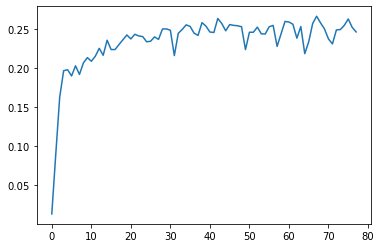

In [8]:
plt.plot(np.asarray(score_list))


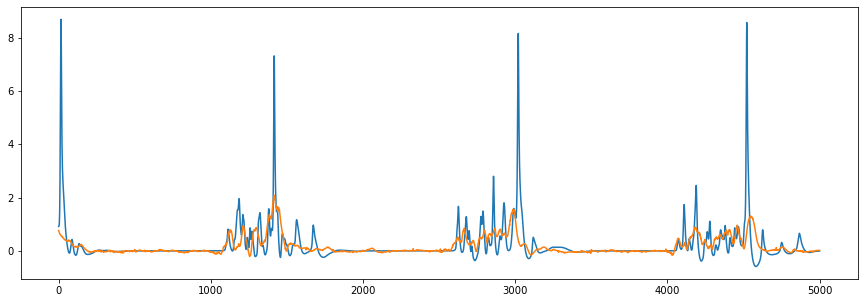

In [7]:
plt.figure(figsize =(15,5))
plt.plot(V_test.flatten().cpu().detach().numpy()[10000:15000])
plt.plot(test_V_pred.flatten().cpu().detach().numpy()[10000:15000])

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_noNA/random/glm_s10_h2.pt")